In [2]:
pip install pymysql

Defaulting to user installation because normal site-packages is not writeable
  Using cached pymysql-1.1.2-py3-none-any.whl.metadata (4.3 kB)
Using cached pymysql-1.1.2-py3-none-any.whl (45 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import pymysql
import pandas as pd
from dotenv import load_dotenv

# Load .env
load_dotenv(dotenv_path='.env')

HOST = os.getenv('HOST')
USER = os.getenv('USER')
PASSWORD = os.getenv('PASSWORD')
PORT = int(os.getenv('PORT'))
DB = os.getenv('DB')

try:
    connection = pymysql.connect(
        host=HOST,
        user=USER,
        password=PASSWORD,
        database=DB,
        port=PORT,
        cursorclass=pymysql.cursors.DictCursor
    )
    print("✅ Connected to Aiven MySQL")

    with connection.cursor() as cur:
        cur.execute("SELECT * FROM coffee_data;")
        rows = cur.fetchall()

    df = pd.DataFrame(rows)
    print("✅ Data loaded:", df.shape)

except Exception as e:
    print("❌ Error while loading data:", e)

finally:
    if 'connection' in locals():
        connection.close()


✅ Connected to Aiven MySQL
✅ Data loaded: (20, 10)


## Kiểm tra tổng quan

In [12]:
# Kiểm tra thông tin tổng quan
df.info()

# Xem tóm tắt thống kê
df.describe()

# Kiểm tra giá trị bị thiếu
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   year                     20 non-null     int64 
 1   temperature              20 non-null     object
 2   humidity                 20 non-null     object
 3   rain                     20 non-null     object
 4   area_thousand_ha         20 non-null     object
 5   output_volumn_tons       19 non-null     object
 6   export_volume_tons       18 non-null     object
 7   export_value_usd         18 non-null     object
 8   price_world_usd_per_ton  20 non-null     object
 9   price_vn_usd_per_ton     18 non-null     object
dtypes: int64(1), object(9)
memory usage: 1.7+ KB
year                       0
temperature                0
humidity                   0
rain                       0
area_thousand_ha           0
output_volumn_tons         1
export_volume_tons         2
export_v

## Loại bỏ dòng hoặc cột trống


In [13]:
# Loại bỏ dòng không có giá trị 'year'
df = df.dropna(subset=['year'])

# Lọc giữ các cột cần thiết (phòng khi có thêm cột NULL)
df = df[['year','temperature','humidity','rain',
         'area_thousand_ha','output_volumn_tons',
         'export_volume_tons','export_value_usd',
         'price_world_usd_per_ton','price_vn_usd_per_ton']]


## Chuyển kiểu dữ liệu đúng chuẩn

In [14]:
df['year'] = df['year'].astype(int)

numeric_cols = [col for col in df.columns if col != 'year']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


## Điền giá trị thiếu (NaN) hợp lý

In [15]:
# Đảm bảo dữ liệu theo thứ tự năm
df = df.sort_values('year').reset_index(drop=True)

# Dùng nội suy tuyến tính cho toàn bộ cột số
df.interpolate(method='linear', inplace=True)

# Với các giá trị thiếu ở đầu hoặc cuối (nếu vẫn còn) → dùng giá trị gần nhất
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)


C:\Users\Phan Tuan Hung\AppData\Local\Temp\ipykernel_18720\3514119077.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\Phan Tuan Hung\AppData\Local\Temp\ipykernel_18720\3514119077.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [16]:
df.isna().sum()

year                       0
temperature                0
humidity                   0
rain                       0
area_thousand_ha           0
output_volumn_tons         0
export_volume_tons         0
export_value_usd           0
price_world_usd_per_ton    0
price_vn_usd_per_ton       0
dtype: int64

In [40]:
df.head(30)
df.to_csv("dataCoffee_cleaning.csv")

## Visualization


Xu hướng sản lượng và xuất khẩu theo năm

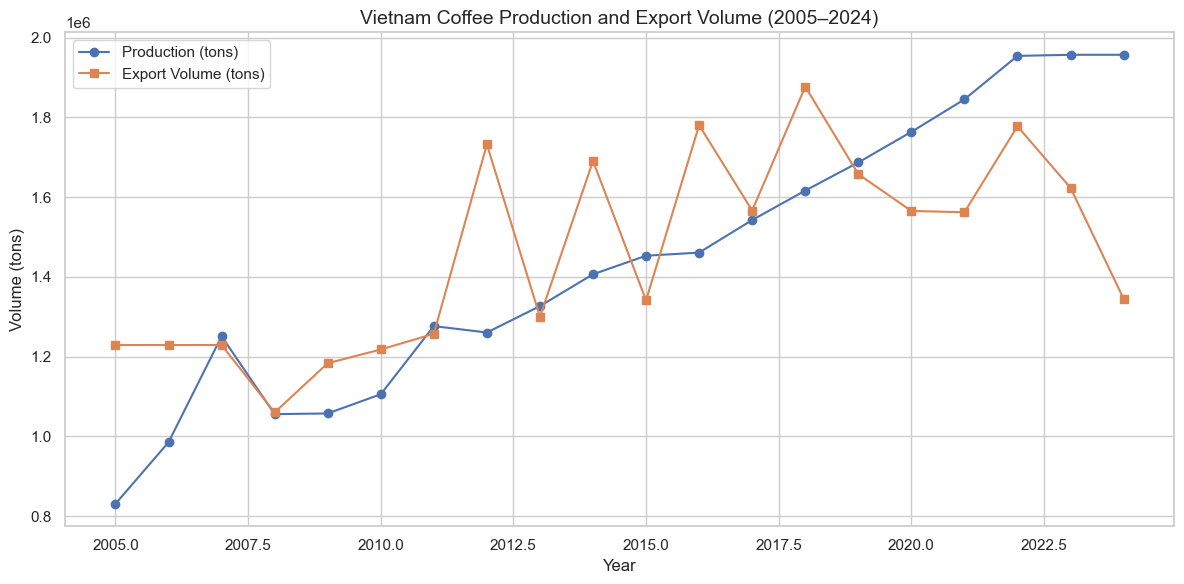

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

plt.plot(df['year'], df['output_volumn_tons'], marker='o', label='Production (tons)')
plt.plot(df['year'], df['export_volume_tons'], marker='s', label='Export Volume (tons)')

plt.title('Vietnam Coffee Production and Export Volume (2005–2024)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Volume (tons)')
plt.legend()
plt.tight_layout()
plt.show()


💡 Insight gợi ý:

Nếu hai đường gần nhau → tỉ lệ xuất khẩu rất cao (Việt Nam xuất gần hết lượng sản xuất).

Khoảng sau 2020 có thể thấy tăng mạnh do giá thế giới phục hồi.

Mối quan hệ giữa giá cafe Việt Nam và thế giới

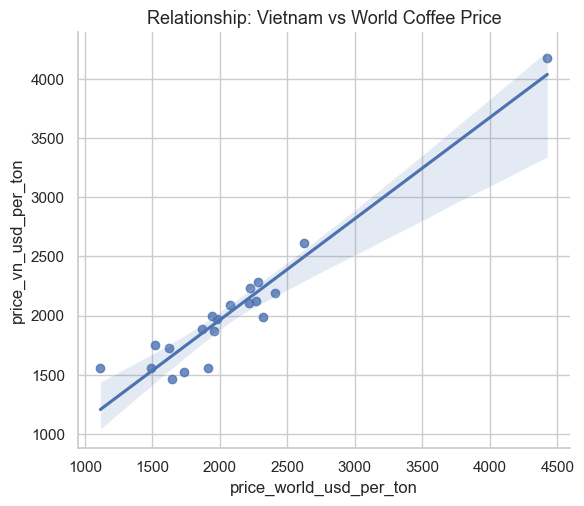

📈 Correlation (VN vs World Price) = 0.96


In [19]:
sns.lmplot(
    data=df,
    x='price_world_usd_per_ton',
    y='price_vn_usd_per_ton',
    height=5,
    aspect=1.2
)
plt.title('Relationship: Vietnam vs World Coffee Price', fontsize=13)
plt.show()

corr = df[['price_world_usd_per_ton','price_vn_usd_per_ton']].corr().iloc[0,1]
print(f"📈 Correlation (VN vs World Price) = {corr:.2f}")


💡 Insight gợi ý:

Nếu hệ số tương quan ≈ 1.0 → giá trong nước gần như phụ thuộc giá thế giới.

Nếu có độ trễ (lag) nhỏ → phản ánh ảnh hưởng theo chu kỳ thu hoạch/xuất khẩu.

Ảnh hưởng của thời tiết đến sản lượng

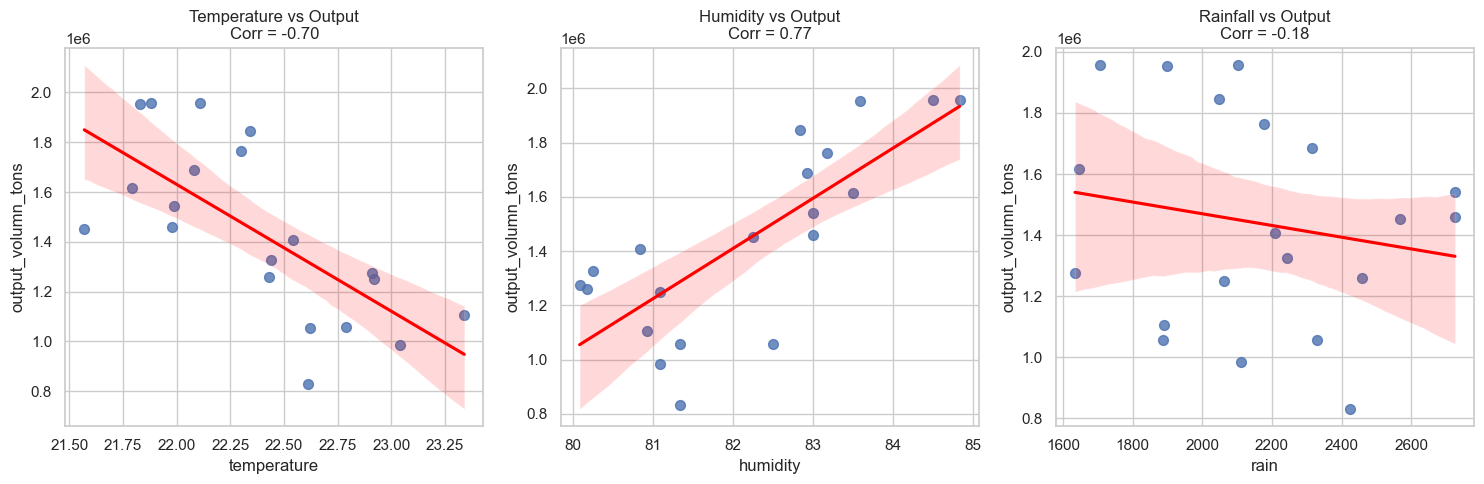

In [31]:
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15,5))
cols = ['temperature', 'humidity', 'rain']
titles = ['Temperature vs Output', 'Humidity vs Output', 'Rainfall vs Output']

for i, col in enumerate(cols):
    sns.regplot(x=col, y='output_volumn_tons', data=df, ax=axs[i],
                scatter_kws={'s':50}, line_kws={'color':'red'})
    corr = np.corrcoef(df[col], df['output_volumn_tons'])[0,1]
    axs[i].set_title(f"{titles[i]}\nCorr = {corr:.2f}")

plt.tight_layout()
plt.show()




Heatmap thể hiện tương quan

💡 Insight gợi ý:

Mưa và độ ẩm có thể tương quan thuận nhẹ với sản lượng.

Nhiệt độ quá cao → sản lượng giảm → ảnh hưởng của biến đổi khí hậu.

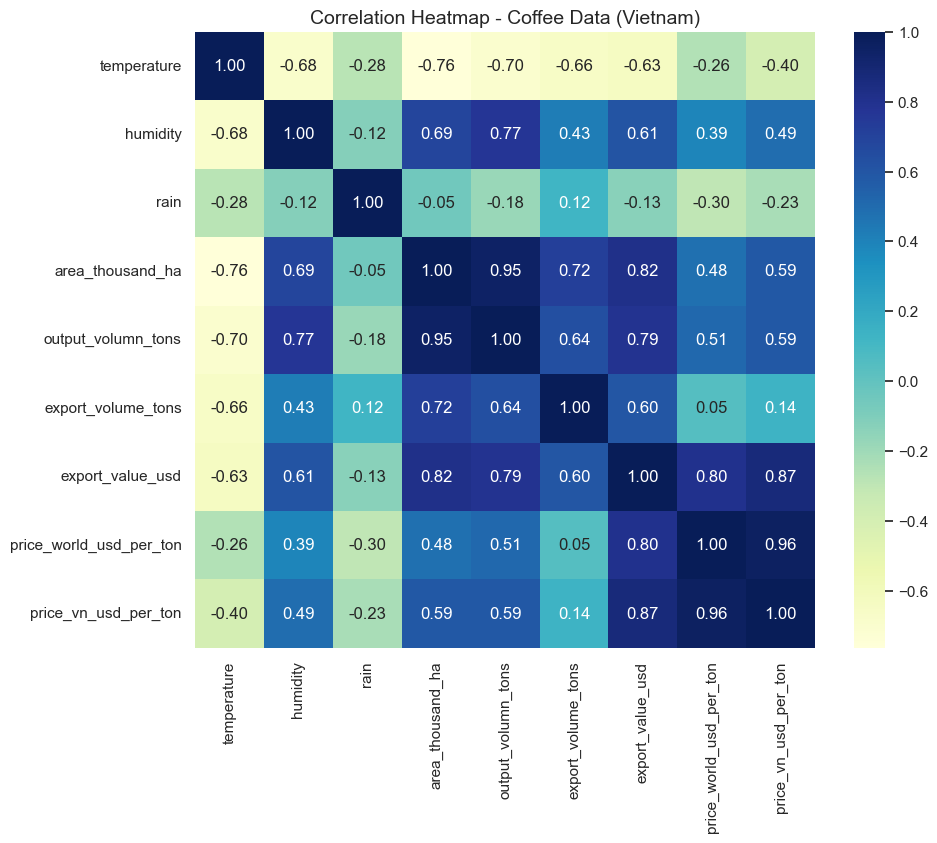

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

# Bỏ cột 'year' trước khi tính ma trận tương quan
corr = df.drop(columns=['year']).corr(numeric_only=True)

sns.heatmap(
    corr,
    annot=True,
    cmap='YlGnBu',
    fmt='.2f'
)

plt.title('Correlation Heatmap - Coffee Data (Vietnam)', fontsize=14)
plt.show()



💡 Insight gợi ý:

output_volumn_tons tương quan cao với rain, area_thousand_ha.

price_vn_usd_per_ton tương quan mạnh với price_world_usd_per_ton.

export_value_usd tăng cùng export_volume_tons → hiệu quả xuất khẩu.

Biểu đồ 2 trục: Giá và sản lượng

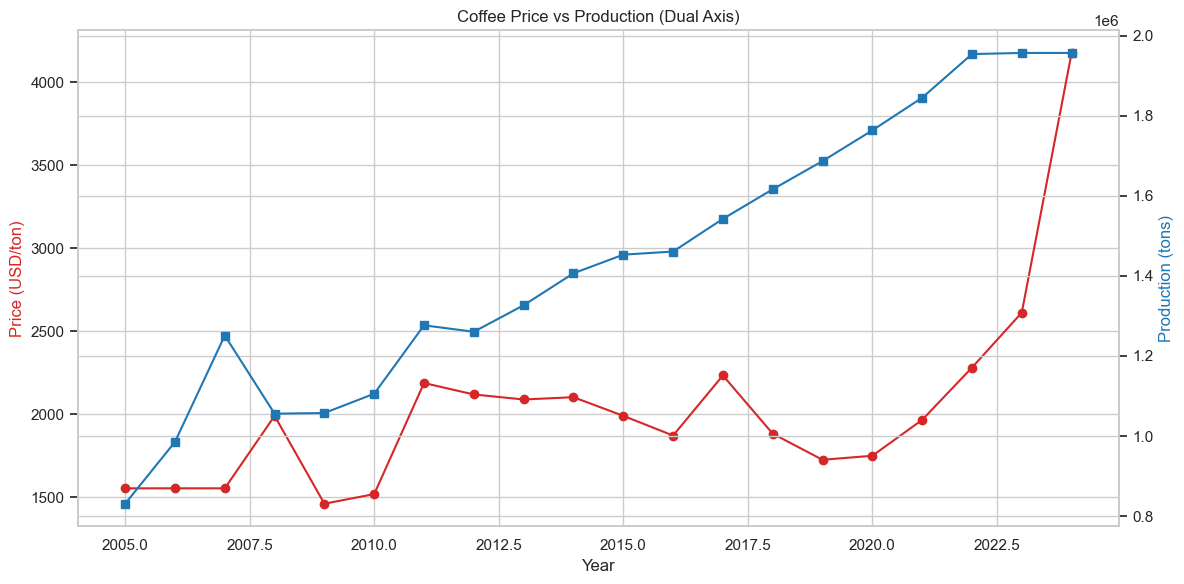

In [29]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()

ax1.plot(df['year'], df['price_vn_usd_per_ton'], color='tab:red', marker='o', label='VN Price (USD/ton)')
ax2.plot(df['year'], df['output_volumn_tons'], color='tab:blue', marker='s', label='Production (tons)')

ax1.set_xlabel('Year')
ax1.set_ylabel('Price (USD/ton)', color='tab:red')
ax2.set_ylabel('Production (tons)', color='tab:blue')
plt.title('Coffee Price vs Production (Dual Axis)')
plt.tight_layout()
plt.show()


💡 Insight gợi ý:

Khi giá tăng → có thể giảm sản lượng do thời tiết hoặc chu kỳ cây trồng.

Khi sản lượng phục hồi → giá có xu hướng giảm nhẹ (do cung tăng).

Biểu đồ so sánh nhiều chỉ số theo năm (Multi-line Trend)

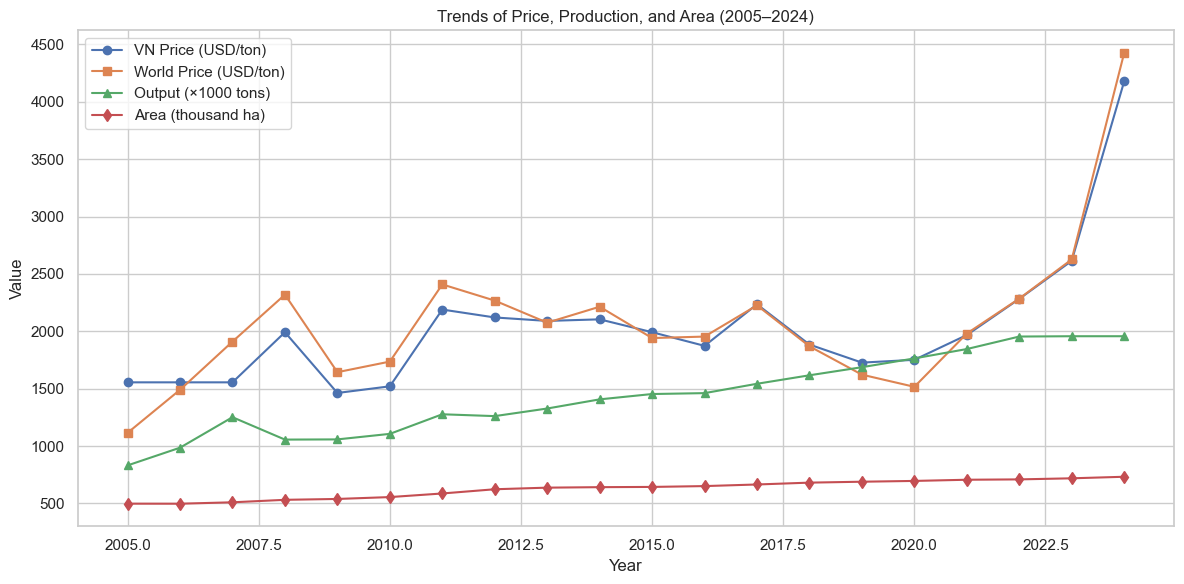

In [32]:
plt.figure(figsize=(12,6))
plt.plot(df['year'], df['price_vn_usd_per_ton'], label='VN Price (USD/ton)', marker='o')
plt.plot(df['year'], df['price_world_usd_per_ton'], label='World Price (USD/ton)', marker='s')
plt.plot(df['year'], df['output_volumn_tons']/1000, label='Output (×1000 tons)', marker='^')
plt.plot(df['year'], df['area_thousand_ha'], label='Area (thousand ha)', marker='d')

plt.title('Trends of Price, Production, and Area (2005–2024)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


💡 Insight:

Giúp thấy rõ chu kỳ tăng/giảm song hành giữa giá – sản lượng – diện tích.

Có thể phát hiện các năm “dị thường” (ví dụ: giá tăng nhưng sản lượng không giảm).

Biểu đồ tương quan giữa Export Value và Export Volume

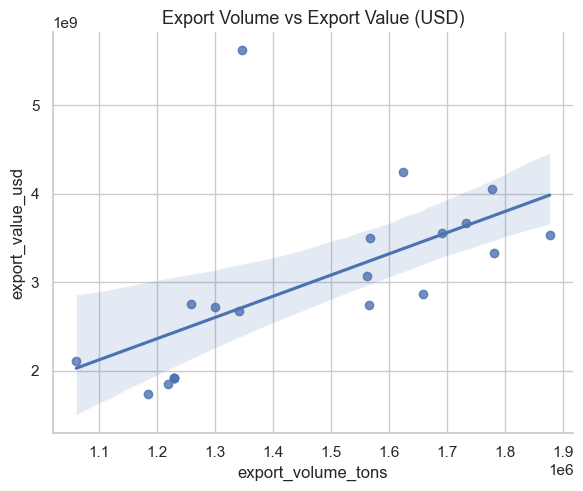

In [33]:
sns.lmplot(
    data=df,
    x='export_volume_tons',
    y='export_value_usd',
    height=5,
    aspect=1.2
)
plt.title('Export Volume vs Export Value (USD)', fontsize=13)
plt.show()


💡 Insight:

Nếu tuyến tính rõ → giá trị xuất khẩu tỷ lệ thuận với lượng.

Nếu xuất hiện năm lệch → có thể do giá cà phê biến động hoặc sản phẩm cao cấp.

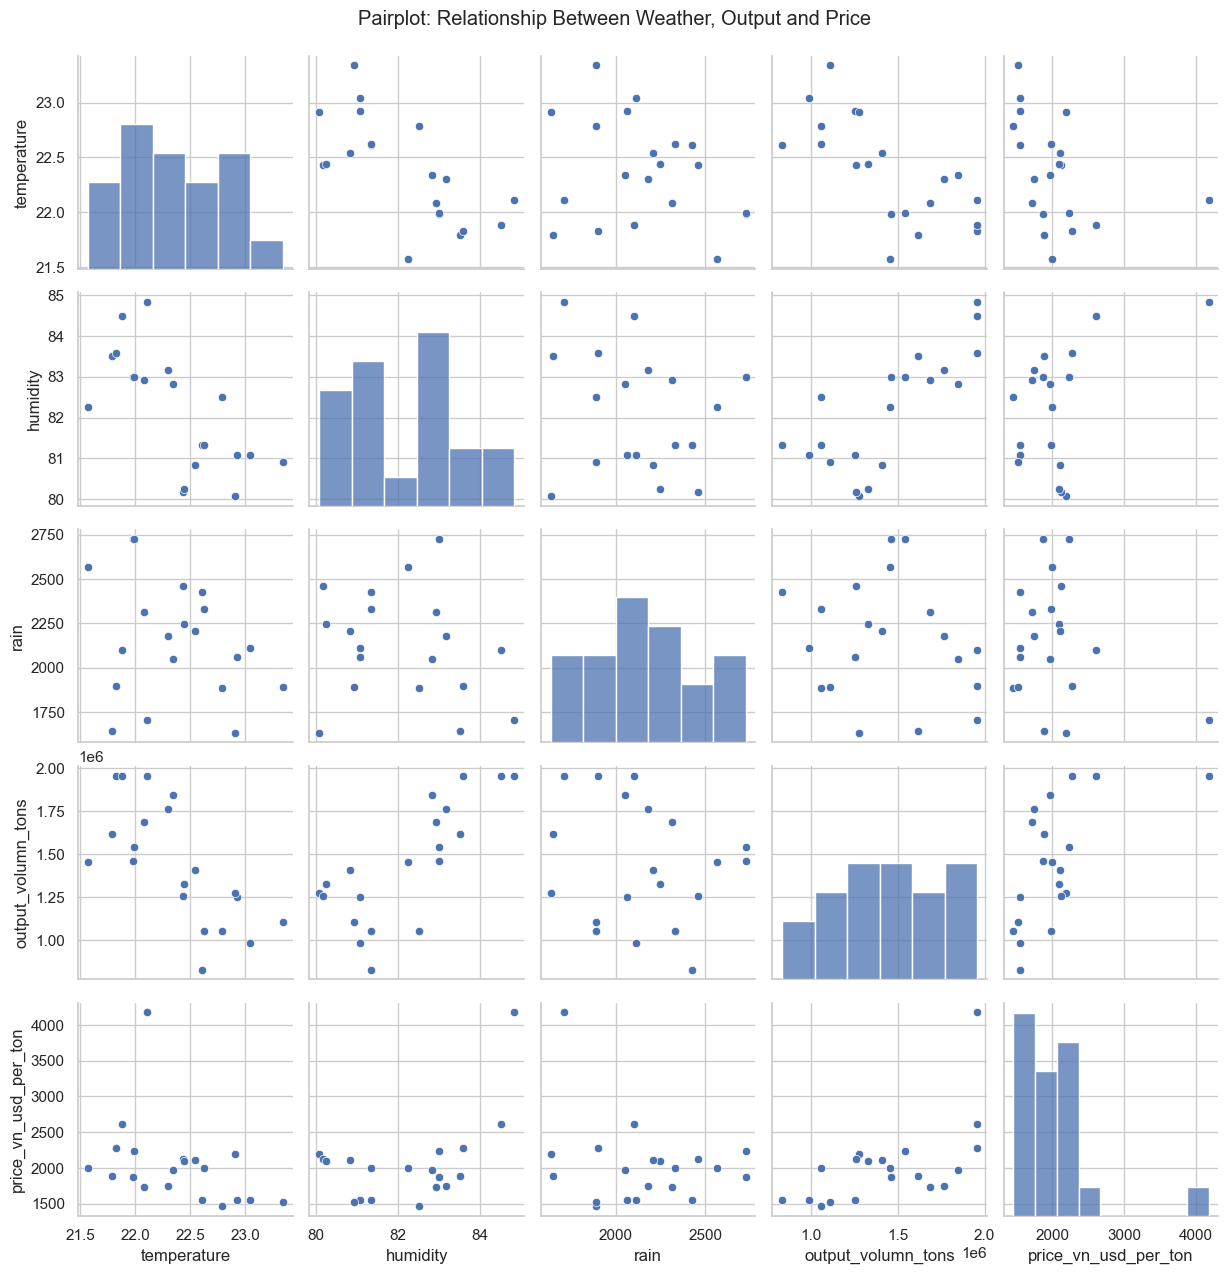

In [39]:
sns.pairplot(df[['temperature','humidity','rain','output_volumn_tons','price_vn_usd_per_ton']])
plt.suptitle("Pairplot: Relationship Between Weather, Output and Price", y=1.02)
plt.show()
